In [50]:
from datetime import datetime, timedelta
import numpy as np
import re
import random
import os
import time
import dill
import yaml
from environment import MiniWoBEnvironment
from utils import find_ref, save_trajectory, name_file, parse_response

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [15]:
from google.cloud import aiplatform
import vertexai.preview
from vertexai.preview.generative_models import GenerativeModel, Part, ChatSession

from PIL import Image
from google.cloud import storage

BUCKET = 'miniwobimages'

project_id = "cs224n-420704"
project_id = "neon-bank-425302-s5"
aiplatform.init(project=project_id)
vertexai.preview.init()
model = GenerativeModel(model_name="gemini-1.5-pro-preview-0514")
#client = storage.Client(project=project_id)
#bucket = client.get_bucket(BUCKET)

In [16]:
with open('config.yaml') as f: config = yaml.safe_load(f)
API_KEY = config['api_key']
MODEL="meta-llama/Llama-3-70b-chat-hf"
SAVE_TO_FOLDER = 'trajectories_train'
DATES = []
MONTHS = ['December', 'November', 'October'
          , 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']

### Choose Date

In [108]:
def get_trajectory_choose_date():
    env_type = 'choose-date'
    action_type = 'CLICK_ELEMENT'
    actions, doms, images, times = [], [], [], []

    def append(action,dom,image):
        actions.append(action)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    goal = observation['utterance']
    date = re.search('Select (.*) as the date', goal).group(1)
    date = datetime.strptime(date, '%m/%d/%Y')
    
    prev_times = 12 - date.month
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    
    action = env.create_action(action_type, ref=5)
    observation, reward, terminated, truncated, info = env.step(action)
    observation, reward, terminated, truncated, info = env.step(action)
    
    action_txt = 'Click on datepicker - {} 5'.format(action_type)
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    
    for i in range(prev_times):
        if i==0:
            ref=10
        else:
            ref = find_ref(dom,'Prev')
        action = env.create_action(action_type, ref=ref)
        observation, reward, terminated, truncated, info = env.step(action)
        
        action_txt = 'Click on Prev to get to the month of {}- {} {}'.format(MONTHS[i+1], action_type, ref)
        dom = observation['dom_elements']
        image = observation['screenshot']
        append(action_txt, dom, image)
    
    day = str(date.day)
    ref = find_ref(dom, day)
    
    action = env.create_action(action_type, ref=ref)
    observation, reward, terminated, truncated, info = env.step(action)

    action_txt = 'Click on day {} of {} because {} is the month displayed now - {} {}'.format(
        day, MONTHS[-date.month], MONTHS[-date.month],  action_type, ref)
    print(action_txt)
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
    
    ref = find_ref(dom, 'Submit')
    
    action = env.create_action(action_type, ref=ref)
    observation, reward, terminated, truncated, info = env.step(action)

    action_txt = 'Click on Submit - {} {}'.format(action_type, ref)
    dom = observation['dom_elements']
    image = observation['screenshot']
    append(action_txt, dom, image)
 
    env.close()
    #save_trajectory(actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_choose_date()

Click on day 21 of August because August is the month displayed now - CLICK_ELEMENT 474


### Book Flight

In [110]:
def ref2text(ref, dom):
    for element in dom:
        if element['ref'] == ref:
            text = element['text']
            return text
    

def get_trajectory_book_flight():   
    env_type = 'book-flight'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    fields = dict(observation['fields'])
    
    goal = observation['utterance']
    from_ = fields['from']
    to_ = fields['to']
    date = datetime.strptime(fields['date'], '%m/%d/%Y')
    criterion = fields['criterion']                               
    prev_times = 12 - date.month
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    action_type, ref, text = action_types[0], 7, ''
    action_txt = 'Click on From input field before entering text - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 7, from_
    action_txt = 'Type {} in From input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 20, ''
    action_txt = 'Click on autocomplete option {} - {} {}'.format(ref2text(ref, doms[-1]),action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 9, ''
    action_txt = 'Click on To input field - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 9, to_
    action_txt = 'Type {} in To input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 24, ''
    action_txt = 'Click on autocomplete option {} - {} {}'.format(ref2text(ref, doms[-1]),action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 13, ''
    action_txt = 'Click on datepicker - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    for i in range(prev_times):
        action_type, text = action_types[0], 'Prev'
        ref = find_ref(doms[-1], text)
        action_txt = 'Click on Prev to get to the month of {} with the final purpose of reaching {}- {} {}'.format(
            MONTHS[i+1], MONTHS[-date.month], action_type, ref)
        execute_action(action_type, ref, text, action_txt)
    
    action_type, text = action_types[0], str(date.day)
    ref = find_ref(doms[-1], text)
    action_txt = 'Click on day {} of {} because {} is the month displayed now - {} {}'.format(
        text, MONTHS[-date.month], MONTHS[-date.month],  action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, text = action_types[0], 'Search'
    ref = find_ref(doms[-1], text)
    action_txt = 'Click on {} - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    instruction = 'Find the {} flight'.format(criterion)
    print(instruction)
    prompt = create_prompt(instruction, doms[-1])
    
    chat = model.start_chat(response_validation = False)
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type = action_types[0]
    text = ref2text(ref, doms[-1])
    action_txt = 'Click on button {} - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    print(reward)
    env.close()
    return #save_trajectory(actions, doms, images, times, env_type, reward, goal)

trajectory = get_trajectory_book_flight()

Find the cheapest flight
Action description: Click the button that books the cheapest flight. It has the text "Book flight for $351".

Dom element ref number: 271 

0.7052666666666667


In [14]:
def create_prompt(goal,dom):

    part1 = '''You are a web-agent capable of reasoning to make decisions based on the information
    you are given. You are able to click on website buttons to select the best option based on the
    criterion provided. For example, you are able to compare durations, to select the shortest flight.

You are given the following goal: 
{}
You observe the following DOM elements from the web-page HTML: {}'''.format(goal,dom)
    part2 = '''
Start by comparing the different choices available and then find
the best answer. Provide your answer for the ONE next action in the following format:

Action description:
'''
    part3 = ''' Once you identified the next action to take, identify the ref number of the element
    on which you need to perform the action. Write your answer in the following format:
    
    Dom element ref number:
    
    \n'''
    
    return part1+part2+part3
#prompt = create_prompt('Find the cheapest flight', trajectory['states'][-1]['dom_elements'])

In [33]:
chat = model.start_chat()
response = chat.send_message(prompt).text
response

'Action description: Click the button to book the flight for $499, as it is the cheapest option.\n\n    Dom element ref number: 175 \n'

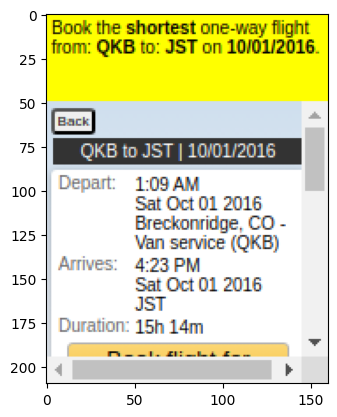

In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(trajectory['states'][-2]['screenshot'])

In [45]:
test = dill.load(open('trajectories_train/book-flight/book-flight031.pkd','rb'))
print(test['utterance'])
print(test['reward'])
[x['action'] for x in test['states']]

Book the cheapest one-way flight from: Akiak, AK to: Dutch Harbor, AK on 11/03/2016.
0.0


['',
 'Click on From input field - CLICK_ELEMENT 7',
 'Type Akiak, AK in From input field - TYPE_TEXT 7',
 'Click on autocomplete option Akiak, AK (AKI) - CLICK_ELEMENT 20',
 'Click on To input field - CLICK_ELEMENT 9',
 'Type Dutch Harbor, AK in To input field - TYPE_TEXT 9',
 'Click on autocomplete option  - CLICK_ELEMENT 24',
 'Click on datepicker - CLICK_ELEMENT 13',
 'Click on Prev to get to the month of November- CLICK_ELEMENT 31',
 'Click on day 3 - CLICK_ELEMENT 160',
 'Click on Search - CLICK_ELEMENT 15',
 'Click on button Search - CLICK_ELEMENT 15']

### Search Engine

In [83]:
8%3

2

In [82]:
from math import ceil

def count_search_results(dom):
    count = 0
    for element in dom:
        if element['classes'] =='search-title':
            count += 1
    return count
    

def get_page_link(page_no, dom):
    text = str(page_no)
    for element in dom:
        if element['classes'] =='page-link' and element['text'] == text:
            return element['ref']
        
def search_page(text, dom):
    for element in dom:
        if element['classes'] =='search-title' and element['text'] == text:
            return element['ref']
    return 0

def get_trajectory_search_engine():   
    env_type = 'search-engine'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        print(action_txt)
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    fields = dict(observation['fields'])

    goal = observation['utterance']
    print(goal)
    query = fields['query']
    rank = int(fields['rank'])
    rank1 = rank*1
    pages = ceil(rank/3) # will not be used to generalize to other environments
    item_not_found = True
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    action_type, ref, text = action_types[0], 5, ''
    action_txt = 'Click on textbox - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 5, query
    action_txt = 'Type {} in textbox - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[0], 6, ''
    action_txt = 'Click on the Search button - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)

    page = 1
    count = 0
    while item_not_found:
        ref = search_page(query, doms[-1])
        if ref > 0:
            item_not_found = False
        else:
            page +=1
            count += count_search_results(doms[-1])
            rank1 = rank1 - count
            ref = get_page_link(page, doms[-1])
            action_type, text = action_types[0], ''
            action_txt = 'Counted {} results so far. Go to page {} because {} was not found on page {} - {} {}'.format(
                count, page, query, page-1, action_type, ref)
            execute_action(action_type, ref, text, action_txt)
        
        
    action_type, text = action_types[0], ''
    action_txt = 'Counted {} results, click Search Title {} in position {} - {} {}'.format(rank, query, rank1, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    env.close()
    return #save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)

dom=get_trajectory_search_engine()

Use the textbox to enter "Rex" and press "Search", then find and click the 4th search result.
Click on textbox - CLICK_ELEMENT 5
Type Rex in textbox - TYPE_TEXT 5
Click on the Search button - CLICK_ELEMENT 6
Counted 3 results so far. Go to page 2 because Rex was not found on page 1 - CLICK_ELEMENT 24
Counted 4 results, click Search Title Rex in position 1 - CLICK_ELEMENT 30
0.87035


In [78]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

In [38]:
test = dill.load(open('trajectories_train/search-engine/search-engine002.pkd','rb'))
[x['action'] for x in test['states']]

['',
 'Click on textbox - CLICK_ELEMENT 5',
 'Type Keneth in textbox - TYPE_TEXT 5',
 'Click on the Search button - CLICK_ELEMENT 6',
 'Go to page 2 because Keneth was not found on page 1 - CLICK_ELEMENT 24',
 'Click on Search Title Keneth - CLICK_ELEMENT 38']

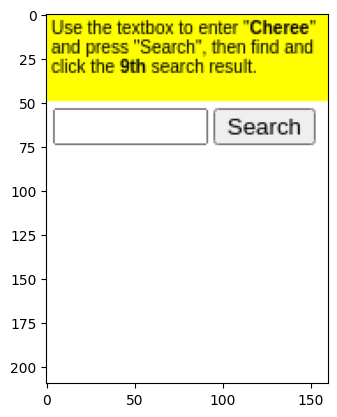

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(test['states'][0]['screenshot'].astype(int))

In [135]:
def count_reward(env_name):
    path = 'trajectories_train/'+env_name
    files = os.listdir(path)
    files = [x for x in files if os.path.isfile(os.path.join(path,x))]
    reward = 0
    n_rewards = 0
    n_pos_rewards =0
    for i in range(len(files)):
        filepath = os.path.join(path, files[i])
        trajectory = dill.load(open(filepath, 'rb'))
        traj_reward = trajectory['reward']
        if traj_reward is not None:
            n_rewards +=1
            if traj_reward >0:
                reward += (traj_reward+1)/2
                n_pos_rewards +=1
    print(n_pos_rewards, len(files))      
    return reward/n_pos_rewards
count_reward('book-flight')

122 200


0.8544612021857921

### Email inbox

In [73]:
def search_item(text, cls, dom):
    for element in dom:
        if element['classes'] ==cls and  element['text'] == text:
            return element['ref']

def find_ref(dom, s):
    for element in dom:
        if element['text'] == s:
            return element['ref']

def find_by_id(id_, dom):
    for element in dom:
        if element['id'] == id_:
            return element['ref']

def get_trajectory_email_inbox():
    env_type = 'email-inbox'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    fields = dict(observation['fields'])
    
    goal = observation['utterance']
    task = fields['task']
    print(task)
    by = fields['by']
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    if task in ['delete', 'star']:
        instruction = '{} the email message by {}'.format(task.capitalize(), by)
        print(instruction)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Click on {} icon - {} {}'.format(task, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
    else:
        ref = search_item(by, 'email-sender', doms[-1])
        action_type, text = action_types[0], ''
        action_txt = 'Click on the thread by {} - {} {}'.format(by,action_type, ref)
        execute_action(action_type, ref, text, action_txt)
        
        ref = find_ref(doms[-1], task.capitalize())
        action_type, text = action_types[0], ''
        action_txt = 'Click on the {} icon - {} {}'.format(task.capitalize(), action_type, ref)
        execute_action(action_type, ref, text, action_txt)
        
        if task == 'forward':
            field = 'to'
            click_on = 'send-forward'
        else:
            field = 'message'
            click_on = 'send-reply'
        text = fields[field]

        instruction = 'Click on the input box next to the word {}'.format(field.capitalize())
        print(instruction)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type = action_types[0]
        action_txt = 'Click on the input box next to the word {} - {} {}'.format(field.capitalize(), action_type, ref)
        execute_action(action_type, ref, text, action_txt)
        
        instruction = 'Enter text {} in the input box next to the word {}'.format(text,field.capitalize())
        print(instruction)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type = action_types[1]
        action_txt = 'Type {} on the input box next to the word {} - {} {}'.format(text, field.capitalize(), action_type, ref)
        execute_action(action_type, ref, text, action_txt)

        ref = find_by_id(click_on, doms[-1])
        action_type = action_types[0]
        action_txt = 'Click on the {} icon - {} {}'.format(click_on, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)

    print(reward)
    env.close()
    save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_email_inbox()

reply
Click on the input box next to the word Message
Action description: Click on the textarea element with id 'reply-text'.

Dom element ref number: 93 

Enter text Lacus natoque. in the input box next to the word Message
Action description: Enter text "Lacus natoque." in the textarea element with id 'reply-text'.

Dom element ref number: 93 

0.0
saved trajectory in file trajectories_train/email-inbox/email-inbox215.pkd


In [72]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

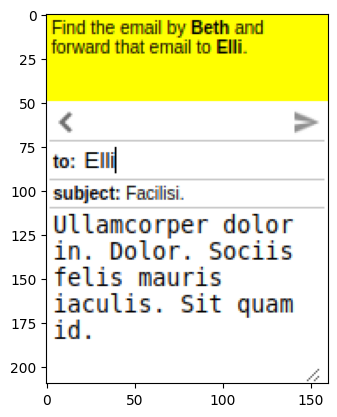

In [60]:
plt.imshow(image)

In [61]:
def coord2ref1(coords, dom):
    ref = 0
    for element in dom:
        if element['left'] < coords[0] \
        and (element['left'] + element['width']) > coords[0] \
        and element['top'] < coords[1] \
        and (element['top'] + element['height']) > coords[1]:
            ref = max(ref, element['ref'])
            id_ = element['text']
    return ref, id_
coord2ref1((150,62), dom)

(85, '')

In [68]:
test = dill.load(open('trajectories_train/email-inbox/email-inbox212.pkd','rb'))
[x['action'] for x in test['states']]

['',
 'Click on the thread by Consolata - CLICK_ELEMENT 91',
 'Click on the Reply icon - CLICK_ELEMENT 114',
 'Click on the input box next to the word Message - CLICK_ELEMENT 129',
 'Type Etiam est, amet. on the input box next to the word Message - TYPE_TEXT 129',
 'Click on the send-reply icon - CLICK_ELEMENT 121']

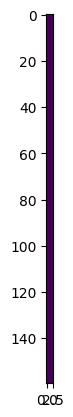

In [94]:
plt.imshow(image.astype(int))

In [95]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

### Click checkboxes

In [105]:
def create_prompt1(goal,dom):

    part1 = '''You are a web-agent capable of reasoning to make decisions based on the information
    you are given. You are able to click on website buttons to select the best option based on the
    criterion provided. For example, you are able to compare durations, to select the shortest flight.

You are given the following goal: 
{}
You observe the following DOM elements from the web-page HTML: {}'''.format(goal,dom)
    part2 = '''
Start by comparing the different choices available and then find
the best answer. Provide your answer for the ONE next action in the following format:

Action description:
'''
    part3 = ''' Once you identified the next action to take, identify the ref number of the element
    on which you need to perform the action. Write your answer in the following format:
    
    Dom element ref number:
    Word:
    \n'''
    
    return part1+part2+part3
def get_trajectory_click_checkboxes_soft():
    env_type = 'click-checkboxes-soft'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        print(action_txt)
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    print(goal)
    n_clicks =len([x for x in observation['fields'] if 'target' in x[0]])
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    
    prompt = create_prompt1(goal, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    text = re.search('Word:[ ]*(.+)',response).group(1)
    action_type = action_types[0]
    action_txt = 'Click on checkbox next to the word {} - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)

    while True:
        prompt = 'Keeping your goal in mind, what would be your next step? If no more steps, write "DONE"'
        response = chat.send_message(prompt).text
        print(response)
        
        if 'DONE' in response:
            break
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        text = re.search('Word:[ ]*(.+)',response).group(1)
        print(text)
        action_type = action_types[0]
        action_txt = 'Click on checkbox next to the word {} - {} {}'.format(text, action_type, ref)
        if 'Submit' in response:
            action_txt = 'Click on the Submit button - {} {}'.format(action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
            
    #action_type, ref, text = action_types[0], find_ref(doms[-1], 'Submit'), ''
    #action_txt = 'Click on the Submit button - {} {}'.format(action_type, ref)
    #reward = execute_action(action_type, ref, text, action_txt)
    print(reward)
    env.close()
    #save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_click_checkboxes_soft()

Select words similar to sinful, mistaken, hide and click Submit.
Action description: Click the checkbox next to the word "sinful" because it is similar to sinful. 

    Dom element ref number: 8
    Word: sinful 

Click on checkbox next to the word  - CLICK_ELEMENT 8
Action description: Click the checkbox next to the word "wrong" because it is similar to mistaken. 

    Dom element ref number: 12
    Word: wrong 

wrong 
Click on checkbox next to the word wrong  - CLICK_ELEMENT 12
Action description: Click the checkbox next to the word "conceal" because it is similar to hide. 

    Dom element ref number: 10
    Word: conceal 

conceal 
Click on checkbox next to the word conceal  - CLICK_ELEMENT 10
Action description: Click the Submit button to submit the selected words.

    Dom element ref number: 15
    Word: Submit 

Submit 
Click on the Submit button - CLICK_ELEMENT 15
DONE 

0.2672


In [93]:
dom

(('target 0', 'fire'), ('button', 'submit'))

### Click tab2 hard

In [37]:
def search_item(text, cls, dom):
    for element in dom:
        if element['classes'] ==cls and  element['text'] == text:
            return element['ref']
    return 0

def get_trajectory_click_tab2_hard():
    env_type = 'click-tab-2-hard'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    fields = dict(observation['fields'])
    target = fields['target']
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    ref1 = 0
    tab_no = 1
    while ref1 == 0:
        ref1 = search_item(target, 'alink', doms[-1])
        if ref1 > 0:
            break
        tab_no += 1
        action_type, text = action_types[0], str(tab_no)
        ref = search_item(text, 'ui-tabs-anchor', doms[-1])
        action_txt = 'Click on tab number {} because the link was not found in tab {} - {} {}'.format(
            tab_no, tab_no - 1, action_type, ref)
        execute_action(action_type, ref, text, action_txt)
    
    action_type, text = action_types[0], target
    action_txt = 'Click on link {}  - {} {}'.format(target, action_type, ref1)
    reward = execute_action(action_type, ref1, text, action_txt)
    print(reward)
    env.close()
    #save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_click_tab2_hard()

0.9941


In [182]:
test = dill.load(open('trajectories_train/click-tab-2-hard/click-tab-2-hard006.pkd','rb'))
[x['action'] for x in test['states']]

['',
 'Click on tab number 2 because the link was not found in tab 1 - CLICK_ELEMENT 8',
 'Click on tab number 3 because the link was not found in tab 2 - CLICK_ELEMENT 10',
 'Click on tab number 4 because the link was not found in tab 3 - CLICK_ELEMENT 12',
 'Click on tab number 5 because the link was not found in tab 4 - CLICK_ELEMENT 14',
 'Click on tab number 6 because the link was not found in tab 5 - CLICK_ELEMENT 16',
 'Click on link Senectus  - CLICK_ELEMENT 55']

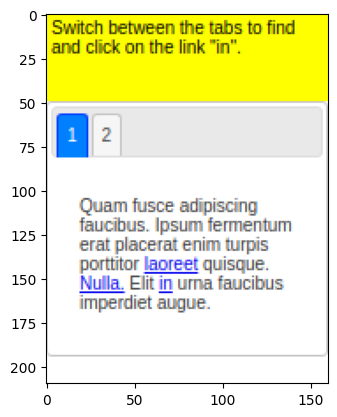

In [171]:
plt.imshow(image)

### Social media

In [40]:
def get_trajectory_social_media():
    env_type = 'social-media'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    fields = dict(observation['fields'])
    user = fields['user']
    button = fields['button']
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    
    if button in ['Like', 'Reply', 'Retweet']:
        prompt = create_prompt(goal, doms[-1])
        print(goal)
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Look for the tweet by {} and click on the {} button - {} {}'.format(
            user, button, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)
    else:
        instruction = 'For user {}, click on the MORE button (3 dots)'.format(user)
        print(instruction)
        prompt = create_prompt(instruction, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Look for the tweet by {} and click on the MORE button (3 dots) - {} {}'.format(
            user, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)

        prompt = create_prompt(goal, doms[-1])
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = 'Select the {} option from the MORE dropdown menu - {} {}'.format(
            button, action_type, ref)
        reward = execute_action(action_type, ref, text, action_txt)

    print(reward)
    env.close()
    #save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 

get_trajectory_social_media()

For the user @michel, click on the "Like" button.
Action description: Click on the "like" button of the media whose username is "@michel".

Dom element ref number: 53 

0.8718


In [203]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

In [232]:
def analyse_social_media():
    path = 'trajectories_gemini/social-media-some'
    files = os.listdir(path)
    files = [x for x in files if os.path.isfile(os.path.join(path,x))]
    score = 0
    reward = 0
    n_rewards = 0
    for i in range(len(files)):
        filepath = os.path.join(path, files[i])
        trajectory = dill.load(open(filepath, 'rb'))
        reward = trajectory['reward']
        goal = trajectory['utterance']
        print(goal,reward)         
    return
analyse_social_media()

Click the "Share" button on 5 posts by @feugiat and then click Submit. -1.0
Click the "Share" button on 1 post by @nathalie and then click Submit. 0.0
Click the "Share" button on 2 posts by @karrie and then click Submit. 0.0
Click the "Reply" button on 1 post by @enola and then click Submit. 0.0
Click the "Retweet" button on 3 posts by @nunc and then click Submit. -1.0
Click the "Like" button on 5 posts by @ashlea and then click Submit. -1.0
Click the "Share" button on 1 post by @cierra and then click Submit. 0.65515
Click the "Share" button on 3 posts by @nisl and then click Submit. -1.0
Click the "Like" button on 2 posts by @macie and then click Submit. -1.0
Click the "Reply" button on 2 posts by @riley and then click Submit. 0.0
Click the "Share" button on 1 post by @leonie and then click Submit. 0.0
Click the "Share" button on 9 posts by @lyda and then click Submit. -1.0
Click the "Share" button on 2 posts by @kasie and then click Submit. 0.0
Click the "Like" button on 1 post by @d

### Social media some

In [132]:
def get_trajectory_social_media_some():
    env_type = 'social-media-some'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        print(action_txt)
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()
    
    goal = observation['utterance']
    fields = dict(observation['fields'])
    order = ['second','third','fourth','fifth','sixth']

    user = fields['user']
    button = fields['button']
    amount = int(fields['amount'])

    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']

    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    chat = model.start_chat(response_validation = False)
    
    instruction = 'Look for the first tweet by {} and click on the {} button'.format(user, button)
    prompt = create_prompt(instruction, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type, text = action_types[0], ''
    action_txt = '{} - {} {}'.format(instruction, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    for i in range(amount-1):
        prompt = 'Look for the {} tweet by {} and click on the {} button'.format(order[i], user,button)
        response = chat.send_message(prompt).text
        print(response)
        ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
        action_type, text = action_types[0], ''
        action_txt = '{} - {} {}'.format(prompt, action_type, ref)
        execute_action(action_type, ref, text, action_txt)

    text = 'Submit'
    action_type, ref = action_types[0], find_ref(doms[-1], text)
    action_txt = 'Click on the {} button - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    #env.close()
    #save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_social_media_some()

Action description: Click on the reply button of the first tweet by @sit.
Dom element ref number: 10 

Look for the first tweet by @sit and click on the Reply button - CLICK_ELEMENT 10
Click on the Submit button - CLICK_ELEMENT 85
0.8472500000000001


Click the "Retweet" button on 1 post by @cras and then click Submit.
0.0


['',
 'Look for a tweet by @cras and click on the Retweet button - CLICK_ELEMENT 11']

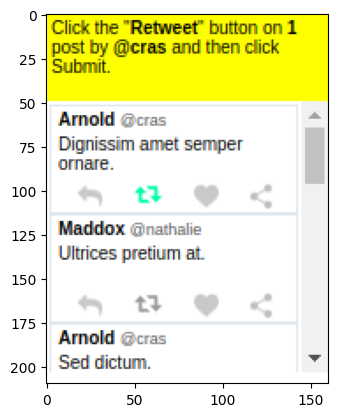

In [239]:
test = dill.load(open('trajectories_train/social-media-some/social-media-some003.pkd','rb'))
print(test['utterance'])
print(test['reward'])
plt.imshow(test['states'][-1]['screenshot'].astype(int))
[x['action'] for x in test['states']]

In [240]:
test['states'][0]['dom_elements']

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

### Use autocomplete

In [121]:
def get_trajectory_use_autocomplete():   
    env_type = 'use-autocomplete'
    action_types = ['CLICK_ELEMENT', 'TYPE_TEXT']
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    fields = dict(observation['fields'])
    goal = observation['utterance']

    start = fields['start']
    end = fields.get('end','')
    if end:
        end = 'and ends with {}'.format(end)
    
    chat = model.start_chat(response_validation = False)
    
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))

    action_type, ref, text = action_types[0], 5, ''
    action_txt = 'Click on input field - {} {}'.format(action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    action_type, ref, text = action_types[1], 5, start
    action_txt = 'Type {} in From input field - {} {}'.format(text, action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    instruction = 'Click on the autocomplete menu option that starts with {} {}'.format(start,end)
    prompt = create_prompt(instruction, doms[-1])
    response = chat.send_message(prompt).text
    print(response)
    ref = int(re.search('Dom element ref number:[\* ]*([0-9]*)',response).group(1))
    action_type, text = action_types[0], ''
    action_txt = '{} - {} {}'.format(instruction,action_type, ref)
    execute_action(action_type, ref, text, action_txt)
    
    text = 'Submit'
    action_type, ref = action_types[0], find_ref(doms[-1], text)
    action_txt = 'Click on the {} button - {} {}'.format(text, action_type, ref)
    reward = execute_action(action_type, ref, text, action_txt)
    
    print(reward)
    #env.close()
    #return save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
dom=get_trajectory_use_autocomplete()

Action description: Click on the autocomplete menu option that starts with "Ru". The text "Russian Federation" matches this criterion. This text is present in the element with 'ref': 10

Dom element ref number: 10 
    
   

0.6301


In [256]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([0.], dtype=float32),
  'top': array([50.], dtype=float32),
  'width': array([160.], dtype=float

### Tic Tac Toe

In [45]:
from collections import Counter
def ref2classes(ref, dom):
    for element in dom:
        if element['ref'] == ref:
            return element['classes']

def update_board(board, dom, refs):
    for i in range(3):
        for j in range(3):
            c = ref2classes(refs[i,j],dom)
            if c:
                board[i,j] = c[-1]
                refs[i,j] = 0
    return board

def next_move(board, refs):
    for i,row in enumerate(board):
        if Counter(row).get('x',0) == 2  and 'o' not in row:
            return refs[i, np.where(row == '')[0][0]]
    for i,row in enumerate(board.T):
        if Counter(row).get('x',0) == 2  and 'o' not in row:
            return refs[np.where(row == '')[0][0], i]
    d1 = np.array([board[0,0],board[1,1],board[2,2]])
    if Counter(d1).get('x',0) == 2  and 'o' not in d1:
        empty = np.where(d1 == '')[0][0]
        return refs[empty,empty]
    d2 = np.array([board[2,0],board[1,1],board[0,2]])
    if Counter(d2).get('x',0) == 2  and 'o' not in d2:
        empty = np.where(d1 == '')[0][0]
        return refs[2-empty,empty]
    
    for i,row in enumerate(board):
        if 'x' in row and '' in row and 'o' not in row:
            return refs[i, np.where(row == '')[0][0]]
    for i,row in enumerate(board.T):
        if 'x' in row and '' in row and 'o' not in row:
            return refs[np.where(row == '')[0][0], i]
    if 'x' in d1 and '' in d1 and 'o' not in d1:
        empty = np.where(d1 == '')[0][0]
        return refs[empty,empty]
    if 'x' in d2 and '' in d2 and 'o' not in d2:
        empty = np.where(d1 == '')[0][0]
        return refs[2-empty,empty]
    if '' in board:
        return refs[np.where(board == '')[0][0],np.where(board == '')[1][0]]
    return 0

def get_trajectory_tic_tac_toe():   
    env_type = 'tic-tac-toe'
    action_type = 'CLICK_ELEMENT'
    actions, doms, images, times = [], [], [], []
    
    def execute_action(action_type, ref, text, action_txt):
        action = env.create_action(action_type, ref=ref, text=text)
        observation, reward, terminated, truncated, info = env.step(action)
        dom = observation['dom_elements']
        image = observation['screenshot']
        actions.append(action_txt)
        doms.append(dom)
        images.append(image)
        times.append(int(time.time()-start_time))
        return reward, info['done']
    
    env = MiniWoBEnvironment(env_type, wait_ms=500,render_mode='human')
    start_time = time.time()
    observation, info = env.reset()

    goal = observation['utterance']
    board = np.array([['','',''],['','',''],['','','']])
    action_txt  = ''
    dom = observation['dom_elements']
    image = observation['screenshot']
    actions.append(action_txt)
    doms.append(dom)
    images.append(image)
    times.append(int(time.time()-start_time))
    
    refs = np.array([[5,6,7],[9,10,11],[13,14,15]])
    board = update_board(board, doms[-1], refs)
    ref = next_move(board, refs)
    action_txt = 'Click on any empty square - {} {}'.format(action_type, ref)

    done = False
    while ref != 0 and not done:
        reward, done = execute_action(action_type, ref, '', action_txt)
        board = update_board(board, doms[-1], refs)
        ref = next_move(board, refs)
        action_txt = '''Click on a square in a row, column or diagonal where there is an X, 
                    an empty space and no O - {} {}'''.format(action_type, ref)
    
    print(reward)
    env.close()
    #save_trajectory(SAVE_TO_FOLDER,actions, doms, images, times, env_type, reward, goal)
    return 
get_trajectory_tic_tac_toe()

0.8034


In [17]:
dom

({'ref': 1,
  'parent': 0,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([500.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'body',
  'text': '',
  'value': '',
  'id': '',
  'classes': '',
  'bg_color': array([0.33333334, 0.33333334, 0.33333334, 1.        ], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([1, 0, 0, 0], dtype=int8)},
 {'ref': 2,
  'parent': 1,
  'left': array([0.], dtype=float32),
  'top': array([0.], dtype=float32),
  'width': array([160.], dtype=float32),
  'height': array([210.], dtype=float32),
  'tag': 'div',
  'text': '',
  'value': '',
  'id': 'wrap',
  'classes': '',
  'bg_color': array([1., 1., 1., 1.], dtype=float32),
  'fg_color': array([0., 0., 0., 1.], dtype=float32),
  'flags': array([0, 0, 0, 0], dtype=int8)},
 {'ref': 3,
  'parent': 2,
  'left': array([10.], dtype=float32),
  'top': array([60.], dtype=float32),
  'width': array([150.], dtype=floa

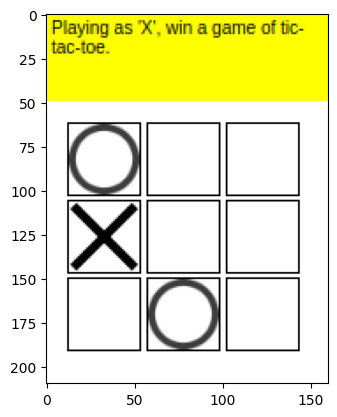

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.imshow(image)

In [28]:
refs = np.array([[5,6,7],[9,10,11],[13,14,15]])
np.where(refs==17)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [52]:
from collections import Counter
board = np.array(['','',''])
Counter(board)

Counter({'': 3})

Playing as 'X', win a game of tic-tac-toe.
0.8709


['',
 'Click on any empty square - CLICK_ELEMENT 5',
 'Click on a square in a row, column or diagonal where there is an X, \n                    an empty space and no O - CLICK_ELEMENT 6',
 'Click on a square in a row, column or diagonal where there is an X, \n                    an empty space and no O - CLICK_ELEMENT 7']

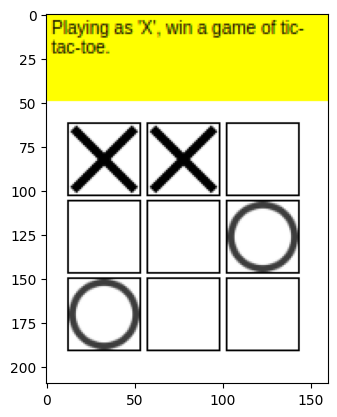

In [60]:
test = dill.load(open('trajectories_train/tic-tac-toe/tic-tac-toe004.pkd','rb'))
print(test['utterance'])
print(test['reward'])
plt.imshow(test['states'][-2]['screenshot'].astype(int))
[x['action'] for x in test['states']]

### Se

In [74]:
from vertexai.preview.generative_models import GenerativeModel
from vertexai.preview import tuning
from vertexai.preview.tuning import sft